# S1 Coursework

In [120]:
#import essential packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import math

#defining the pdfs 
from scipy.stats import crystalball, norm

#for finding maximum of total pdf, curve fit
from scipy.optimize import minimize, curve_fit

#EML fit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

#sWeights package
from sweights import SWeight

#timing how long functions take
import timeit

#show the loading bar
from tqdm import tqdm

#plotting uncertainties
from uncertainties import ufloat

import seaborn as sns

## Part c: Defining the p.d.f.s

Only $g_s(X)$ and the normalistaion factor of $h_b(Y)$ is defined using the scipy stats package because writing out the equations instead of using a package seems to run faster.\
They are all normalised in the region $X \in [0,5]$ and $Y \in [0,10]$.\
The marginal and joint (total) distributions are also defined.

In [121]:
#define the functions using scipy stats 
#commented out scipy stats functions because they are slower
#defined equations instead

#signal for X
def g_s(X, beta, m, mu, sigma):
    return crystalball.pdf(X, beta, m, mu, sigma) / (crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma))

# def h_s(Y, lmbda):
#     trunc_b = (10.0 - 0.0)*lmbda
#     return truncexpon.pdf(Y, trunc_b, 0.0, 1/lmbda)


#signal for Y
def h_s(Y, lmbda):
    pdf = lmbda * np.exp(-lmbda * Y)
    norm_factor = 1 - np.exp(-10 * lmbda)
    return pdf / norm_factor

# def g_b(X):
#     return uniform.pdf(X, 0.0, 5.0)

#background for X
def g_b(X):
    if isinstance(X, (float, int)): #scalar input
        return 1/5.0 if 0 <= X <= 5 else 0
    else:  # numpy array input
        return np.where((X >= 0) & (X <= 5), 1/5.0, 0)

# def h_b(Y, mu_b, sigma_b):
#     a = (mu_b - 0.0)/sigma_b
#     b = (10.0 - mu_b)/sigma_b
#     return truncnorm.pdf(Y, a, b, mu_b, sigma_b)

#background for Y
def h_b(Y, mu_b, sigma_b):
    pdf = (1/(sigma_b * np.sqrt(2*np.pi))) * np.exp(-(Y - mu_b)**2 / (2*sigma_b**2))
    norm_factor = norm.cdf(10, mu_b, sigma_b) - norm.cdf(0, mu_b, sigma_b)
    return pdf / norm_factor

#marginal distribution in X
def marg_X(X, f, mu, sigma, beta, m):
    return f*g_s(X, beta, m, mu, sigma) + (1-f)*g_b(X)

#marginal distribution in Y
def marg_Y(Y, f, lmbda, mu_b, sigma_b):
    return f*h_s (Y, lmbda) + (1-f)*h_b(Y, mu_b, sigma_b)

#total signal distribution
def signal(X, Y, mu, sigma, beta, m, f, lmbda):
    return f * g_s(X, beta, m, mu, sigma) * h_s(Y, lmbda)

#total background distribution 
def background(X, Y, f, mu_b, sigma_b):
    return (1-f) * g_b(X) * h_b(Y, mu_b, sigma_b)

#total joint distribution
def total(X, Y, mu, sigma, beta, m, f, lmbda, mu_b, sigma_b):
    return signal(X, Y, mu, sigma, beta, m, f, lmbda) + background(X, Y, f, mu_b, sigma_b)


Plot the distribution.

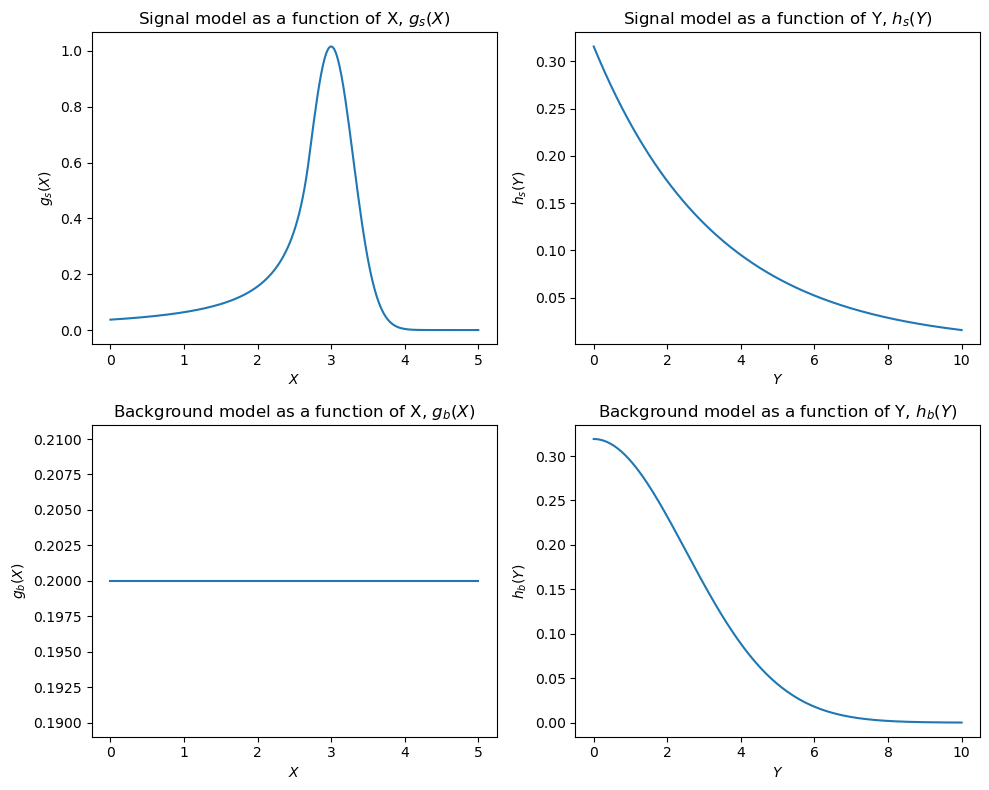

In [122]:
#Plot the graph
mu_true = 3.0
sigma_true = 0.3
beta_true = 1.0
m_true = 1.4
f_true = 0.6
lmbda_true = 0.3
mu_b_true = 0.0
sigma_b_true = 2.5

# Create a 2x2 grid of plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8)) 

x = np.linspace(0, 5, 200)
y = np.linspace(0, 10, 200)

#plot the signal for X
ax[0,0].plot(x, g_s(x, beta_true, m_true, mu_true, sigma_true))
ax[0,0].set_title(r'Signal model as a function of X, $g_s(X)$')
ax[0,0].set_ylabel(r'$g_s(X)$')
ax[0,0].set_xlabel(r'$X$')

#plot the signal for Y
ax[0,1].plot(y, h_s(y, lmbda_true))
ax[0,1].set_title(r'Signal model as a function of Y, $h_s(Y)$')
ax[0,1].set_ylabel(r'$h_s(Y)$')
ax[0,1].set_xlabel(r'$Y$')

#plot the background for X
ax[1,0].plot(x, g_b(x))
ax[1,0].set_title(r'Background model as a function of X, $g_b(X)$')
ax[1,0].set_ylabel(r'$g_b(X)$')
ax[1,0].set_xlabel(r'$X$')

#plot the background for Y
ax[1,1].plot(y, h_b(y, mu_b_true, sigma_b_true))
ax[1,1].set_title(r'Background model as a function of Y, $h_b(Y)$')
ax[1,1].set_ylabel(r'$h_b(Y)$')
ax[1,1].set_xlabel(r'$Y$')

plt.tight_layout()

Check that these graphs are sufficiently normalised.

In [123]:
#Check that the pdfs are normalised

def random_params():
    params = {
        'mu': np.random.normal(2.5, 0.5),  
        'sigma': np.random.uniform(0.2, 0.8),  
        'beta': np.random.uniform(2, 5),
        'm': np.random.uniform(1.5, 4), 
        'f': np.random.uniform(0, 1),
        'lmbda': np.random.uniform(0.5, 2), 
        'mu_b': np.random.uniform(1, 2), 
        'sigma_b': np.random.uniform(0.2, 0.8)
    }
    return params

def check_normalisation(num = 100, tolerance = 1e-5):
    passed = 0
    for _ in range(num):
        params = random_params()
        mu = params['mu']
        sigma = params['sigma']
        beta = params['beta']
        m = params['m']
        f = params['f']
        lmbda = params['lmbda']
        mu_b = params['mu_b']
        sigma_b = params['sigma_b']

        integral_g_s = scipy.integrate.quad(lambda x: g_s(x, beta, m, mu, sigma), 0, 5)
        integral_h_s = scipy.integrate.quad(lambda y: h_s(y, lmbda), 0, 10)
        integral_g_b = scipy.integrate.quad(g_b, 0, 5)
        integral_h_b = scipy.integrate.quad(lambda y: h_b(y, mu_b, sigma_b), 0, 10)

        if math.isclose(integral_g_s[0], 1, rel_tol= tolerance) and math.isclose(integral_h_s[0], 1, rel_tol= tolerance) and math.isclose(integral_g_b[0], 1, rel_tol= tolerance) and math.isclose(integral_h_b[0], 1, rel_tol= tolerance):
            passed+=1
        else:
            print(params) #print the parameters that were not normalised
    return passed/num


In [124]:
#run this to check normalisation. should be = 1
print(check_normalisation())

1.0


Plot the marginal distributions in X and Y.

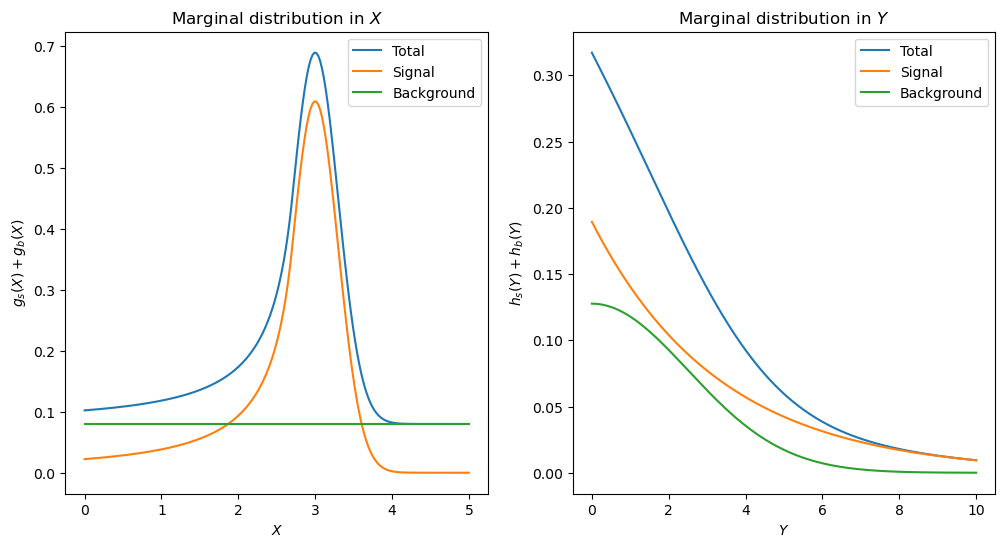

In [125]:
#Plot marginal distributions 
fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
ax[0].plot(x, marg_X(x, f_true, mu_true, sigma_true, beta_true, m_true), label = 'Total')
ax[0].plot(x, f_true*g_s(x, beta_true, m_true, mu_true, sigma_true), label = 'Signal')
ax[0].plot(x, (1-f_true)*g_b(x), label = 'Background')
ax[0].set_xlabel(r'$X$')
ax[0].set_ylabel(r'$g_s(X)+g_b(X)$')
ax[0].set_title(r'Marginal distribution in $X$')
ax[0].legend()

ax[1].plot(y, marg_Y(y, f_true, lmbda_true, mu_b_true, sigma_b_true), label = 'Total')
ax[1].plot(y, f_true*h_s(y, lmbda_true), label = 'Signal')
ax[1].plot(y, (1-f_true)*h_b(y, mu_b_true, sigma_b_true), label = 'Background')
ax[1].set_xlabel(r'$Y$')
ax[1].set_ylabel(r'$h_s(Y)+h_b(Y)$')
ax[1].set_title(r'Marginal distribution in $Y$')
ax[1].legend()

Plot the total distribtution contour.

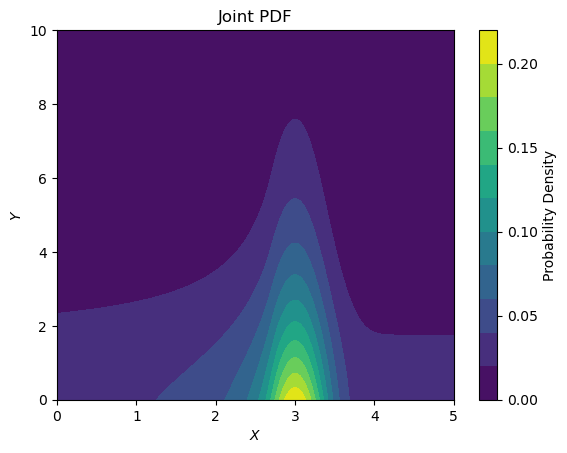

In [126]:
#Plot the total distribution for both X and Y

X, Y = np.meshgrid(x,y)

contour = plt.contourf(X, Y, total(X, Y, mu_true, sigma_true, beta_true, m_true, f_true, lmbda_true, mu_b_true, sigma_b_true), levels = 10, cmap = 'viridis')
cbar = plt.colorbar(contour)
cbar.set_label("Probability Density")
cbar.set_ticks([0, 0.05, 0.1, 0.15, 0.2])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('Joint PDF')
plt.savefig('plots/2d_joint_pdf.png')

Plot the total distribution - 3d plot.

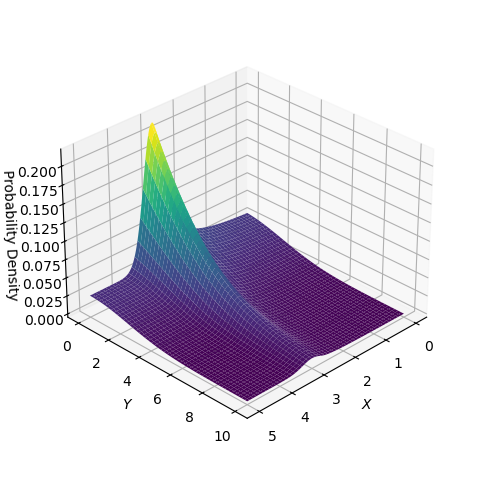

In [127]:
#Plot the 3d joint pdf
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('Probability Density', labelpad = 5)
joint3d = ax.plot_surface(X, Y, total(X, Y, mu_true, sigma_true, beta_true, m_true, f_true, lmbda_true, mu_b_true, sigma_b_true), cmap='viridis' )
ax.view_init(elev=30, azim=45)

ax.set_box_aspect(None, zoom=0.87)

plt.savefig('plots/3d_joint_plot.png')

## Part d: Generate a high statistics sample
Make an accept reject sampler to sample from this distribution.\
First make a function to find the maximum of the joint distribution.

In [13]:
#Create find max of this 2d function
def find_fmax_2d(func, x_range = (0.0, 5.0), y_range = (0.0, 10.0)):
    f_to_min = lambda vars: -func(vars[0], vars[1])
    initial_guess = [0,1]
    result = minimize(f_to_min, x0 = initial_guess, bounds = [x_range, y_range])
    max_x, max_y = result.x
    max_f = func(max_x, max_y)
    return max_f

#Define total with fixed params
def total_fixed(X, Y):
    return total(
        X, Y, 
        mu=mu_true, sigma=sigma_true, beta=beta_true, m=m_true, 
        f=f_true, lmbda=lmbda_true, mu_b=mu_b_true, sigma_b=sigma_b_true
    )
f_max = find_fmax_2d(total_fixed)

In [14]:
f_max #check value

0.21804724535029035

In [15]:
#quicker accept reject sampler
def accept_reject_2d(func, x_range = [0, 5], y_range = [0, 10], num_samples=50, seed=1, batch_size=1000):

    np.random.seed(seed)
    
    x_samples = []
    y_samples = []

    f_max = find_fmax_2d(func)
    
    while len(x_samples) < num_samples:
        # Generate a batch of random samples
        x_temp = np.random.uniform(x_range[0], x_range[1], batch_size)
        y_temp = np.random.uniform(y_range[0], y_range[1], batch_size)
        f_temp = np.random.uniform(0, f_max, batch_size)
        
        # Evaluate the function for the batch
        f_values = func(x_temp, y_temp)
        
        # Apply the acceptance criterion
        accepted = f_temp < f_values
        
        # Append accepted samples
        x_samples.extend(x_temp[accepted])
        y_samples.extend(y_temp[accepted])
    
    # Convert lists to arrays and trim to the desired number of samples
    x_samples = np.array(x_samples[:num_samples])
    y_samples = np.array(y_samples[:num_samples])
    
    return x_samples, y_samples

In [16]:
#save down the 100k sample 
total_pdf_sample = accept_reject_2d(total_fixed,num_samples = 100000, seed = 100)
#np.savetxt('data_storage/joint_pdf_sample_s100.csv', total_pdf_sample, delimiter=',', header = 'X,Y', comments = '')

Plot the true distributions as well as the histograms with sampled data\
Some of these I just make for the report.

C:\Users\eliza\AppData\Local\Temp\ipykernel_32732\1827417405.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[0].errorbar( Xcx, Xnh, Xerrors, fmt='ko', color= 'black', label = 'Sampled data')


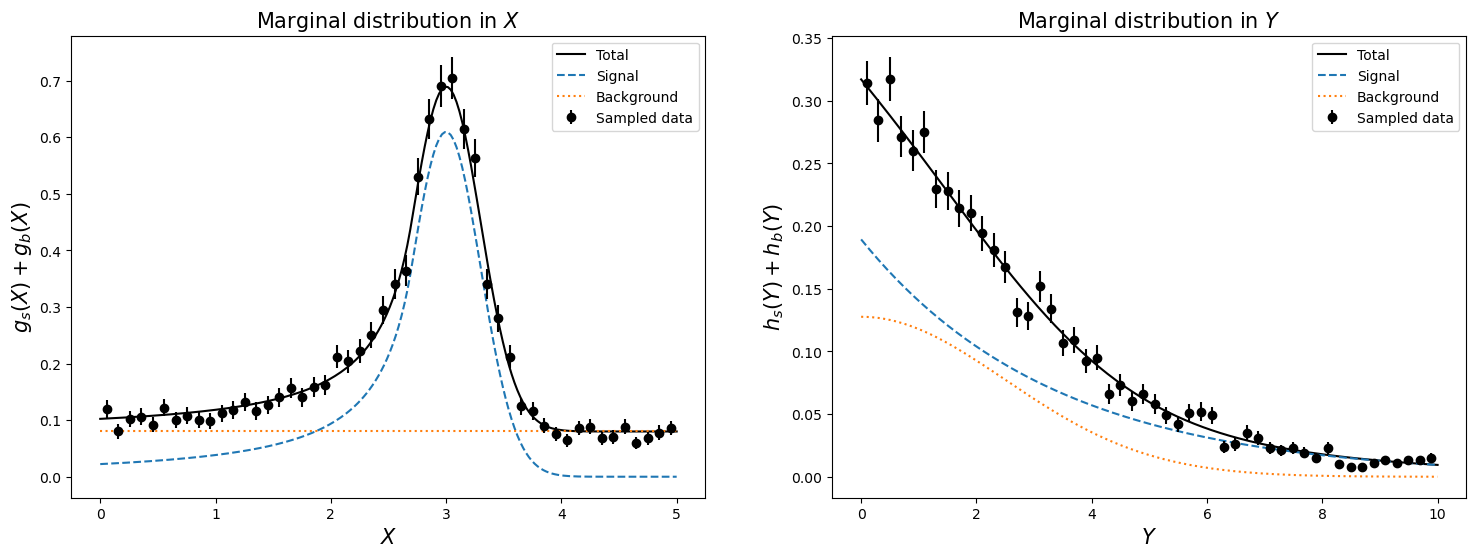

In [130]:
data = accept_reject_2d(total_fixed,num_samples = 5000, seed = 100)
fontsize = 15

X, Y = data

bin_num = 50

#Plot marginal distributions 
fig, ax = plt.subplots(1, 2, figsize=(18, 6)) 

Xnh, Xxe = np.histogram(X, bins = bin_num, density=True)
Xcx = 0.5*(Xxe[:-1] + Xxe[1:])

#compute error on histogram with error prop
Xbin_widths = np.diff(Xxe)
Xcounts, _ = np.histogram(X, bins= bin_num)  # Raw counts (not normalized)
Xerrors = np.sqrt(Xcounts) / (len(X) * Xbin_widths)

ax[0].plot(x, marg_X(x, f_true, mu_true, sigma_true, beta_true, m_true), label = 'Total', color = 'black')
ax[0].plot(x, f_true*g_s(x, beta_true, m_true, mu_true, sigma_true), label = 'Signal', ls = '--')
ax[0].plot(x, (1-f_true)*g_b(x), label = 'Background', ls = ':')
ax[0].errorbar( Xcx, Xnh, Xerrors, fmt='ko', color= 'black', label = 'Sampled data')
ax[0].set_xlabel(r'$X$', fontsize=fontsize)
ax[0].set_ylabel(r'$g_s(X)+g_b(X)$', fontsize=fontsize)
ax[0].set_title(r'Marginal distribution in $X$', fontsize=fontsize)
ax[0].legend()

Ynh, Yxe = np.histogram(Y, bins = bin_num, density=True)
Ycx = 0.5*(Yxe[:-1] + Yxe[1:])

#compute error on histogram with error prop
Ybin_widths = np.diff(Yxe)
Ycounts, _ = np.histogram(Y, bins= bin_num)  # Raw counts (not normalized)
Yerrors = np.sqrt(Ycounts) / (len(Y) * Ybin_widths)

ax[1].plot(y, marg_Y(y, f_true, lmbda_true, mu_b_true, sigma_b_true), label = 'Total', color = 'black')
ax[1].plot(y, f_true*h_s(y, lmbda_true), label = 'Signal', ls = '--')
ax[1].plot(y, (1-f_true)*h_b(y, mu_b_true, sigma_b_true), label = 'Background', ls = ':')
ax[1].errorbar( Ycx, Ynh, Yerrors, fmt='o', color= 'black', label = 'Sampled data')
ax[1].set_xlabel(r'$Y$', fontsize=fontsize)
ax[1].set_ylabel(r'$h_s(Y)+h_b(Y)$', fontsize=fontsize)
ax[1].set_title(r'Marginal distribution in $Y$', fontsize=fontsize)
ax[1].legend()

plt.savefig('plots/marginal_distributions.png')

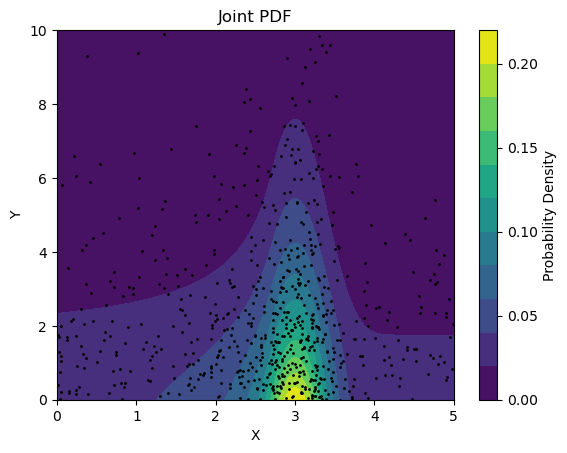

In [15]:
Xt, Yt = np.meshgrid(x,y)

data = accept_reject_2d(total_fixed,num_samples = 700, seed = 100)

X, Y = data

contour = plt.contourf(Xt, Yt, total(Xt, Yt, mu_true, sigma_true, beta_true, m_true, f_true, lmbda_true, mu_b_true, sigma_b_true), levels = 10, cmap = 'viridis')
plt.scatter(X, Y , s =1 , color = 'black', alpha = 1)
cbar = plt.colorbar(contour)
cbar.set_label("Probability Density")
cbar.set_ticks([0, 0.05, 0.1, 0.15, 0.2])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Joint PDF')
plt.savefig('plots/joint_dist_scatter.png') #i dont know how i feel about this plot

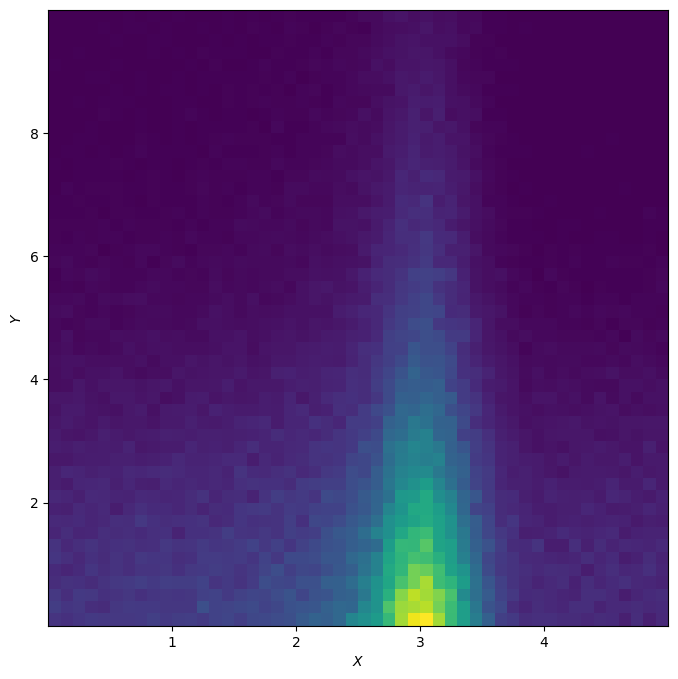

In [16]:
data = accept_reject_2d(total_fixed,num_samples = 150000, seed = 100)
X, Y = data
fig = plt.figure(figsize=(8, 8))
plt.hist2d(X, Y, bins = 50)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.savefig('plots/joint_dist_hist.png')
plt.show()

C:\Users\eliza\AppData\Local\Temp\ipykernel_32732\1592206419.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for colorbar


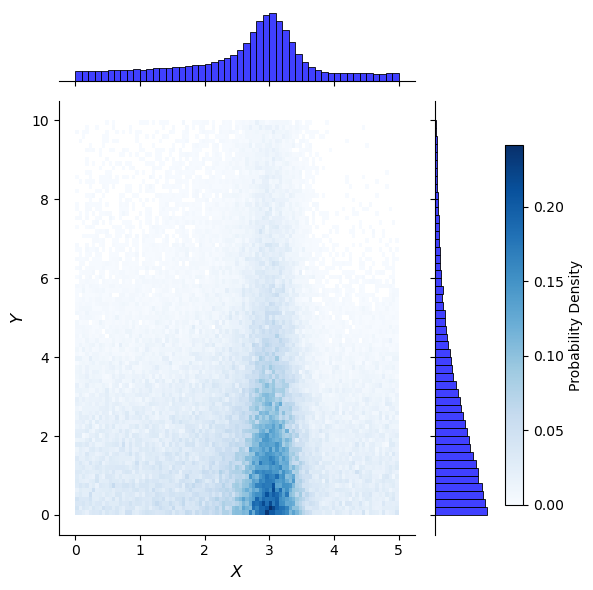

In [26]:
#plot a histogram using the high statistics sample data

data = np.loadtxt('data_storage/joint_pdf_sample_s100.csv', delimiter=',', skiprows=1)
X, Y = data

hist2d = sns.jointplot(x=X, y=Y, kind='hist', bins='auto', marginal_kws=dict(bins=50, fill=True, color='blue'), cmap='Blues', stat = 'density')

# Add colorbar manually
cbar_ax = hist2d.fig.add_axes([0.85, 0.15, 0.03, 0.6])  # Position: [x, y, width, height]
cb = plt.colorbar(hist2d.ax_joint.collections[0], cax=cbar_ax)
cb.set_label('Probability Density')

# Set axis labels
hist2d.set_axis_labels(r"$X$", r"$Y$", fontsize=12)

# Adjust layout to avoid label cutoff
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for colorbar

plt.savefig('plots/joint_dist_hist_sns.png')
plt.show()

Perform the maximum extended maximum likelihood fit to the 100k sample data.

In [27]:
#Extended maximum likelihood fit on the data

#load the data
data = np.loadtxt('data_storage/joint_pdf_sample_s100.csv', delimiter=',', skiprows=1)
X, Y = data
N_true = len(X)

#Create the model for EML fit - extra param N for number of samples
def model_density(data, N, mu, sigma, beta, m, f, lmbda, mu_b, sigma_b):

    X, Y = data

    #define pdfs again here, because it is quicker for the minimiser
    g_s = crystalball.pdf(X, beta, m, mu, sigma) / (crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma))
    
    #trunc_b = (5.0 - 0.0)*lmbda
    #h_s = truncexpon.pdf(Y, trunc_b, 0.0, 1/lmbda)

    pdf_h_s = lmbda * np.exp(-lmbda * Y)
    norm_factor_h_s = 1 - np.exp(-10 * lmbda)
    h_s = pdf_h_s/norm_factor_h_s

    #g_b = uniform.pdf(X, 0.0, 5.0)
    g_b = np.where((X >= 0) & (X <= 5), 1/5.0, 0)

    # a = (0.0 - mu_b)/sigma_b
    # b = (10.0 - mu_b)/sigma_b
    # h_b = truncnorm.pdf(Y, a, b, mu_b, sigma_b)

    pdf_h_b = (1/(sigma_b * np.sqrt(2*np.pi))) * np.exp(-(Y - mu_b)**2 / (2*sigma_b**2))
    norm_factor_h_b = norm.cdf(10, mu_b, sigma_b) - norm.cdf(0, mu_b, sigma_b)
    h_b = pdf_h_b/norm_factor_h_b

    signal = f * g_s * h_s
    background = (1-f) * g_b * h_b

    total = signal + background

    return N, N*total

Starting parameters I use for the fit are the true parameters + a bit of Gaussian noise on the same scale as the true parameters. 

In [28]:
#Save fit starting parameters to use in the future 

np.random.seed(42)
noise = np.random.normal(0, 1, size = 9) #add noise to true params
noisy_params = {
    'N_noisy': N_true * (1 + noise[0]),
    'mu_noisy': mu_true * (1 + noise[1]),
    'sigma_noisy': sigma_true * (1 + noise[2]),
    'beta_noisy': beta_true * (1 + noise[3]),
    'm_noisy': m_true * (1 + noise[4]),
    'f_noisy': max(0, min(f_true * (1 + noise[5]), 1)),  # Clamp f_noisy to [0, 1]
    'lmbda_noisy': lmbda_true * (1 + noise[6]),
    'mu_b_noisy': mu_b_true * (1 + noise[7]),
    'sigma_b_noisy': sigma_b_true * (1 + noise[8])
}
#df = pd.DataFrame([noisy_params]) 
#df.to_csv('data_storage/noisy_params.csv', index=False)
noisy_params = dict(pd.read_csv('data_storage/noisy_params.csv'))

In [29]:
#these params do not go out of bounds 
N_noisy = float(noisy_params['N_noisy'][0])
mu_noisy = float(noisy_params['mu_noisy'][0])
sigma_noisy = float(noisy_params['sigma_noisy'][0])
beta_noisy = float(noisy_params['beta_noisy'][0])
m_noisy = float(noisy_params['m_noisy'][0])
f_noisy = float(noisy_params['f_noisy'][0])
lmbda_noisy = float(noisy_params['lmbda_noisy'][0])
mu_b_noisy = float(noisy_params['mu_b_noisy'][0])
sigma_b_noisy = float(noisy_params['sigma_b_noisy'][0])

In [30]:
#make the cost function which is the negative log likelihood
#This fit use the true parameters as starting values
def EML_fit_true(): #using the true params as starting values
    nll = ExtendedUnbinnedNLL((X,Y), model_density)

    #Input starting values
    mi = Minuit(nll, 
                N=N_true,
                mu=mu_true,
                sigma=sigma_true,
                beta=beta_true,
                m=m_true,
                f=f_true,
                lmbda=lmbda_true,
                mu_b=mu_b_true,
                sigma_b=sigma_b_true)

    #input limits
    mi.limits["N"] = (0, None)
    # mi.limits["mu"] = (0, None)
    # mi.limits["sigma"] = (0, None)
    mi.limits["beta"] = (0, None)
    mi.limits["m"] = (1, None)
    # mi.limits["lmbda"] = (0, None)
    # mi.limits["mu_b"] = (-5, 5)
    # mi.limits["sigma_b"] = (0, None)
    # mi.limits["f"] = (0, 1)

    mi.migrad()
    mi.hesse()
    #mi.minos()
    

    return mi
mi = EML_fit_true()

In [31]:
mi

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.462e+06                 │              Nfcn = 303              │
│ EDM = 0.000122 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N       │ 100.00e3  │  0.32e3   │            │            │    0    │         │       │
│ 1 │ mu      │  3.0072   │  0.0025   │            │            │         │         │       │
│ 2 │ sigma   │  0.2960   │  0.0024   │            │            │         │         │       │
│ 3 │ beta    │   0.971   │   0.021   │            │            │    0    │         │       │
│ 4 │ m       │   1.48    │   0.07    │            │            │    1    │         │       │
│ 5 │ f       │   0.601   │   0.004   │            │            │         │         │       │
│ 6 │ lmbda   │  0.2996   │  0.0021   │            │            │         │         │       │
│ 7 │ mu_b    │   0.02    │   0.08    │            │            │         │         │       │
│ 8 │ sigma_b │   2.48    │   0.04    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │         N        mu     sigma      beta         m         f     lmbda      mu_b   sigma_b │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│       N │  1.02e+05     -6e-6    -43e-6         0    -0.000 -0.042e-3    -41e-6    -0.002    0.0006 │
│      mu │     -6e-6  6.42e-06     -3e-6    -27e-6     51e-6     -0e-6     -0e-6     -2e-6      1e-6 │
│   sigma │    -43e-6     -3e-6  5.58e-06     22e-6    -46e-6      2e-6      0e-6     14e-6     -8e-6 │
│    beta │         0    -27e-6     22e-6  0.000449   -1.2e-3  0.008e-3      1e-6    0.1e-3        -0 │
│       m │    -0.000     51e-6    -46e-6   -1.2e-3    0.0043 -0.088e-3    -13e-6    -0.001    0.0003 │
│       f │ -0.042e-3     -0e-6      2e-6  0.008e-3 -0.088e-3  1.26e-05      2e-6  0.047e-3 -0.028e-3 │
│   lmbda │    -41e-6     -0e-6      0e-6      1e-6    -13e-6      2e-6  4.22e-06     11e-6      3e-6 │
│    mu_b │    -0.002     -2e-6     14e-6    0.1e-3    -0.001  0.047e-3     11e-6   0.00593   -0.0026 │
│ sigma_b │    0.0006      1e-6     -8e-6        -0    0.0003 -0.028e-3      3e-6   -0.0026   0.00129 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [36]:
#This fit uses the noisy starting parameters for initial fit params
def EML_fit_noisy():
    nll = ExtendedUnbinnedNLL((X,Y), model_density)

    #Input starting values
    mi = Minuit(nll, 
                N=float(noisy_params['N_noisy'][0]),
                mu=float(noisy_params['mu_noisy'][0]),
                sigma=float(noisy_params['sigma_noisy'][0]),
                beta=float(noisy_params['beta_noisy'][0]),
                m=float(noisy_params['m_noisy'][0]),
                f=float(noisy_params['f_noisy'][0]),
                lmbda=float(noisy_params['lmbda_noisy'][0]),
                mu_b=float(noisy_params['mu_b_noisy'][0]),
                sigma_b=float(noisy_params['sigma_b_noisy'][0])
                )

    #input limits
    mi.limits["N"] = (0, None)
    mi.limits["beta"] = (0, None)
    mi.limits["m"] = (1, None)

    mi.migrad()
    mi.hesse()

    return mi

mi_noisy = EML_fit_noisy()

In [35]:
mi_noisy

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.462e+06                 │              Nfcn = 613              │
│ EDM = 0.000108 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N       │ 100.00e3  │  0.32e3   │            │            │    0    │         │       │
│ 1 │ mu      │  3.0072   │  0.0026   │            │            │         │         │       │
│ 2 │ sigma   │  0.2960   │  0.0024   │            │            │         │         │       │
│ 3 │ beta    │   0.971   │   0.022   │            │            │    0    │         │       │
│ 4 │ m       │   1.48    │   0.07    │            │            │    1    │         │       │
│ 5 │ f       │   0.600   │   0.004   │            │            │         │         │       │
│ 6 │ lmbda   │  0.2996   │  0.0021   │            │            │         │         │       │
│ 7 │ mu_b    │   0.02    │   0.08    │            │            │         │         │       │
│ 8 │ sigma_b │   2.48    │   0.04    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │         N        mu     sigma      beta         m         f     lmbda      mu_b   sigma_b │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│       N │  9.94e+04    -37e-6     36e-6    0.7e-3    -0.002  0.027e-3     18e-6    -0.002    0.0008 │
│      mu │    -37e-6  6.55e-06     -3e-6    -29e-6     59e-6     -0e-6     -0e-6     -3e-6      2e-6 │
│   sigma │     36e-6     -3e-6   5.7e-06     24e-6    -54e-6      3e-6      0e-6     15e-6     -9e-6 │
│    beta │    0.7e-3    -29e-6     24e-6  0.000494   -1.3e-3  0.010e-3      1e-6    0.1e-3   -0.1e-3 │
│       m │    -0.002     59e-6    -54e-6   -1.3e-3   0.00471 -0.094e-3    -14e-6    -0.001    0.0004 │
│       f │  0.027e-3     -0e-6      3e-6  0.010e-3 -0.094e-3  1.27e-05      2e-6  0.048e-3 -0.028e-3 │
│   lmbda │     18e-6     -0e-6      0e-6      1e-6    -14e-6      2e-6  4.23e-06     11e-6      3e-6 │
│    mu_b │    -0.002     -3e-6     15e-6    0.1e-3    -0.001  0.048e-3     11e-6   0.00594   -0.0026 │
│ sigma_b │    0.0008      2e-6     -9e-6   -0.1e-3    0.0004 -0.028e-3      3e-6   -0.0026   0.00129 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [34]:
mi.valid == True

True

In [39]:
def normal_call():
    np.random.normal(size = 100000)

In [ ]:
#save the values using the true parameters as guesses

#np.savetxt('data_storage/fitted_values.csv', list(mi_noisy.values), delimiter = ',')
#np.savetxt('data_storage/fitted_errors.csv', list(mi_noisy.errors), delimiter = ',')

In [40]:
#Run each of these 100 times
time_taken_normal = timeit.timeit(normal_call, number = 100)
time_taken_sampler = timeit.timeit(lambda: accept_reject_2d(total_fixed, num_samples = 100000, seed = 100), number = 100)
time_taken_EML_noisy = timeit.timeit(EML_fit_noisy, number = 100)   
time_taken_EML_true= timeit.timeit(EML_fit_true, number = 100)  

In [43]:
iterations = 100
print(f"Time for normal_call: {time_taken_normal/iterations:.4f} seconds")
print(f"Time for accept_reject_2d: {time_taken_sampler/iterations:.4f} seconds")
print(f"Time for EML_fit_noisy: {time_taken_EML_noisy/iterations:.4f} seconds")
print(f"Time for EML_fit_true: {time_taken_EML_true/iterations:.4f} seconds")

times = [time_taken_normal, time_taken_sampler, time_taken_EML_noisy, time_taken_EML_true]
np.savetxt('data_storage/timings.csv', times, delimiter=',')

Time for normal_call: 0.0013 seconds
Time for accept_reject_2d: 0.8146 seconds
Time for EML_fit_noisy: 21.4916 seconds
Time for EML_fit_true: 9.0146 seconds


(array([3.0020899 , 3.00244283, 3.00279577, 3.0031487 , 3.00350163,
        3.00385456, 3.00420749, 3.00456042, 3.00491335, 3.00526628,
        3.00561921, 3.00597214, 3.00632507, 3.00667801, 3.00703094,
        3.00738387, 3.0077368 , 3.00808973, 3.00844266, 3.00879559,
        3.00914852, 3.00950145, 3.00985438, 3.01020732, 3.01056025,
        3.01091318, 3.01126611, 3.01161904, 3.01197197, 3.0123249 ]),
 array([4.03767151e+00, 3.49883850e+00, 2.99849756e+00, 2.53679518e+00,
        2.11403080e+00, 1.73011968e+00, 1.38502545e+00, 1.07833706e+00,
        8.09895728e-01, 5.79648409e-01, 3.87562983e-01, 2.33739733e-01,
        1.17979522e-01, 4.02877305e-02, 1.83057366e-03, 0.00000000e+00,
        3.59638541e-02, 1.10081375e-01, 2.21687733e-01, 3.70639025e-01,
        5.56586580e-01, 7.79128157e-01, 1.03783247e+00, 1.33284190e+00,
        1.66398072e+00, 2.03096841e+00, 2.43317002e+00, 2.87029343e+00,
        3.34231927e+00, 3.84932857e+00]))

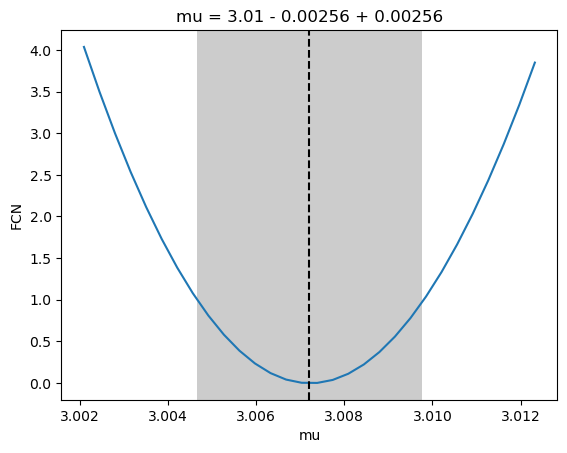

In [45]:
mi_noisy.draw_mnprofile("mu")

## Part e: Parametric bootstrapping

Use the fitted parameters from the 100k sample to plot these bootstraps. Because in real life we won't have the true values.

In [48]:
#Parametric bootstrapping
#ensembles of 250 samples. Each sample has size 500, 1000, 2500, 5000, 10000

N_sample = [500, 1000, 2500, 5000, 10000] #number of samples per toy
param_names = ['N', '\mu', '\sigma', '\\beta', 'm', 'f', '\lambda', '\mu_b', '\sigma_b']
true_values = [3, 0.3, 1, 1.4, 0.6, 0.3, 0, 2.5]#except N which differs
fitted_values = np.loadtxt('data_storage/fitted_values.csv', delimiter=',')
fitted_values = fitted_values[1:] #get rid of the N value because we will change this for each bootstrap

#create new joint distribution with fitted parameters instead
def total_fixed_fitted(X, Y):
    return total(
        X, Y, 
        mu=fitted_values[0], sigma=fitted_values[1], beta=fitted_values[2], m=fitted_values[3], 
        f=fitted_values[4], lmbda=fitted_values[5], mu_b=fitted_values[6], sigma_b=fitted_values[7]
    )

#Make a bootstrap of size N
def generate_bootstrap (N, seed = 1):
    #generate poisson number of events
    N = np.random.poisson(N)

    #generate from model 
    #total_fixed uses the true parameters to generate samples
    x_samples, y_samples = accept_reject_2d(total_fixed_fitted, num_samples=N, seed = seed)
    
    return x_samples, y_samples

#make an ensemble of these bootstrapped value 
def generate_ensemble(N_sample, N_ensemble = 250):
    toys = [generate_bootstrap(N_sample, seed= i) for i in tqdm(range(N_ensemble))]
    return toys 

#fit a sample using the fitted values 
def fit_model(data, N_sample):
    X, Y = data
    nll = ExtendedUnbinnedNLL((X,Y), model_density)
    #starting params
    mi = Minuit(nll, 
            N=N_sample,
            mu=fitted_values[0], 
            sigma=fitted_values[1], 
            beta=fitted_values[2], 
            m=fitted_values[3], 
            f=fitted_values[4], 
            lmbda=fitted_values[5], 
            mu_b=fitted_values[6], 
            sigma_b=fitted_values[7])
    #limits
    mi.limits["N"] = (0, None)
    mi.limits["beta"] = (0, 10)
    mi.limits["m"] = (1, 10)
    mi.limits['sigma'] = (0,None)
    mi.limits['sigma_b'] = (0, None)

    mi.migrad()
    mi.hesse()

    return mi 

In [49]:
def plot(vals, ax=None, param_name=None, plot_param=False, plot_var=False):
    ax = ax or plt.gca()
    
    # Only apply parameter constraints for parameter value plots, not for variance
    if plot_param:
        if param_name == 'm':
            vals = vals[vals > 1]
        elif param_name == 'beta':
            vals = vals[vals > 0]
    elif plot_var:
        vals = vals[vals >= 0]  # Only ensure variances are non-negative
    
    # Check if we have enough data points
    if len(vals) <= 1:
        print(f"Warning: Not enough data points for {param_name} (n={len(vals)})")
        return
    
    # Remove outliers (5%)
    lower_percentile = np.percentile(vals, 2.5)
    upper_percentile = np.percentile(vals, 97.5)
    filtered_vals = vals[(vals >= lower_percentile) & (vals <= upper_percentile)]
    
    # Compute statistics using filtered values
    mean = np.mean(filtered_vals)
    std = np.std(filtered_vals, ddof=1) #bessel correction

    # if std < 1e-10:  # If standard deviation is very small
    #     std = max(std, mean * 1e-3)
    mean_err = std / len(filtered_vals)**0.5
    std_err = std/(2*len(filtered_vals)-1)**0.5 
    
    # Handle std calculation carefully
    if len(filtered_vals) > 1:
        std = np.std(filtered_vals, ddof=1)
    else:
        std = 0.1 * mean  # Use a reasonable default
        print(f"Warning: Using default std for {param_name}")
    
    if plot_var:
        plot_range = (max(0, mean - 3*std), mean + 3*std)
    elif plot_param:
        if param_name == 'm':
            plot_range = (max(mean - 3*std, 1), mean + 3*std)
        elif param_name == 'beta':
            plot_range = (max(mean - 3*std, 0), mean + 3*std)
        else:
            plot_range = (mean - 3*std, mean + 3*std)
    else:
        plot_range = (mean - 3*std, mean + 3*std)

    # Density histograms
    nh, xe = np.histogram(filtered_vals, range=plot_range, bins='auto', density=True)
    ax.hist(filtered_vals, bins=xe, density=True, alpha=0.5)
    
    # Error bars
    sf = np.sum(nh)/len(filtered_vals)
    cx = 0.5 * (xe[1:]+xe[:-1])
    ax.errorbar(cx, nh, sf*(nh/sf)**0.5, fmt='ko')
    
    # Draw normal distribution only over valid range
    x = np.linspace(plot_range[0], plot_range[1], 100)
    ax.plot(x, norm.pdf(x, mean, std), 'r-')
    
    # Plot results
    mean_u = ufloat(mean, mean_err)
    std_u = ufloat(std, std_err)
    mstr = f'{mean_u:.1u}'.replace('+/-', '\pm')
    sstr = f'{std_u:.1u}'.replace('+/-', '\pm')
    ax.text(0.01, 0.92, f'$\hat{{\mu}}= {mstr}$', transform=ax.transAxes)
    ax.text(0.01, 0.86, f'$\hat{{\sigma}} = {sstr}$', transform=ax.transAxes)

In [50]:
def bootstrap(N_sample, N_ensemble = 250):
    #generate toys 
    toys = generate_ensemble(N_sample, N_ensemble= N_ensemble)
    print('Finished generating samples')
    values = []
    errors = []
    invalid_fits = 0
    print('Fitting samples.')
    #fit all of the toys
    for toy in tqdm(toys):
        mi = fit_model(toy, N_sample)
        if mi.valid:
            values.append(list(mi.values))
            errors.append(list(mi.errors))
        else:
            invalid_fits += 1
        #print(len(mi.values))

    #get the values, errors and pulls
    values = np.array(values)
    #print(len(values[0]))
    errors = np.array(errors)
    #print(errors)
    fitted_values_t = np.concatenate((np.array([N_sample]), fitted_values))
    #print(len(fitted_values_t))
    pulls = (values - fitted_values_t)/errors

    np.savetxt(f'data_storage/bootstraps/bootstrap_{N_sample}.csv', 
           np.column_stack((values, errors, pulls)), 
           delimiter=',',
           header='values, errors, pulls')
    
    print(f'Invalid fits are {invalid_fits} out of {N_sample} samples')

    return values, errors, pulls

In [21]:
#run bootstraps

#for n in N_sample:
    #bootstrap(n, 500)

100%|██████████| 500/500 [00:13<00:00, 36.27it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


Invalid fits are 15 out of 500 samples


100%|██████████| 500/500 [00:14<00:00, 35.59it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [02:19<00:00,  3.59it/s]


Invalid fits are 22 out of 1000 samples


100%|██████████| 500/500 [00:24<00:00, 20.65it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [03:49<00:00,  2.17it/s]


Invalid fits are 14 out of 2500 samples


100%|██████████| 500/500 [00:42<00:00, 11.68it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [07:54<00:00,  1.05it/s]


Invalid fits are 12 out of 5000 samples


100%|██████████| 500/500 [02:37<00:00,  3.17it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [08:41<00:00,  1.04s/it]

Invalid fits are 9 out of 10000 samples


In [131]:
def plot_toys(N_sample, values, errors, pulls, param_names):
    fitted_values_t = np.concatenate((np.array([N_sample]), fitted_values))
    
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 3, figsize=(19.2, 24))
    
    for i, name in tqdm(enumerate(param_names), total = len(param_names)):
        # Format parameter name for LaTeX
        base_name = name.split('_')[0]
        estname = f"\\hat{{{base_name}}}"
        if len(name.split('_')) > 1:
            estname += '_' + name.split('_')[1]
        
        # Parameter values plot
        ax = axes[i, 0]
        plot(values[:, i], ax, param_name=base_name, plot_param = True)
        ax.set_xlabel(f"${estname}$")
        
        # Variance plot (errors squared)
        ax = axes[i, 1]
        plot(errors[:, i]**2, ax, param_name=base_name, plot_var = True)
        ax.set_xlabel(f"$\\hat{{V}}({name})$")
        
        # Pulls plot
        ax = axes[i, 2]
        plot(pulls[:, i], ax, param_name=name.split('_')[0])
        ax.set_xlabel(f"$p({estname})$")
        
        # Add vertical lines for true values in the first column
        if i < len(fitted_values_t):
            axes[i, 0].axvline(fitted_values_t[i], color='r', linestyle='--', alpha=0.5)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'data_storage/bootstraps/plots_500/bootstrap_{N_sample}.png')
    plt.show()
    
    return fig, axes

In [69]:
N_sample

[500, 1000, 2500, 5000, 10000]

In [52]:
# # Load the data
# data = np.loadtxt(f'data_storage/bootstraps/bootstrap_10000.csv', 
#                   delimiter=',',
#                   skiprows=1)  # Skip the header row
# #split the data back into values, errors, pulls

#Only take thr first 450 samples because I want them all to have the same length but I cut away the invalid miniuit fits
def load_data (data, cut_val = 450):
    n_params = len(fitted_values)+1
    values = data[:, :n_params]
    errors = data[:, n_params:2*n_params]
    pulls = data[:, 2*n_params:3*n_params]
    return values[:cut_val], errors[:cut_val], pulls[:cut_val]
#plot_toys(10000, values, errors, pulls, param_names)

Plot the bias in the lambda parameter for different sample sizes. Bias is \
$Bias (\hat{\theta}) = E(\hat{\theta})-\theta_{true}$

In [53]:
#Load all the saved data
data_500 = np.loadtxt(f'data_storage/bootstraps/bootstrap_500.csv', delimiter=',',skiprows=1)
data_1000 = np.loadtxt(f'data_storage/bootstraps/bootstrap_1000.csv', delimiter=',',skiprows=1)
data_2500 = np.loadtxt(f'data_storage/bootstraps/bootstrap_2500.csv', delimiter=',',skiprows=1)
data_5000 = np.loadtxt(f'data_storage/bootstraps/bootstrap_5000.csv', delimiter=',',skiprows=1)
data_10000 = np.loadtxt(f'data_storage/bootstraps/bootstrap_10000.csv', delimiter=',',skiprows=1)

data_list = [data_500, data_1000, data_2500, data_5000, data_10000]


In [60]:
param_names

['N', '\\mu', '\\sigma', '\\beta', 'm', 'f', '\\lambda', '\\mu_b', '\\sigma_b']

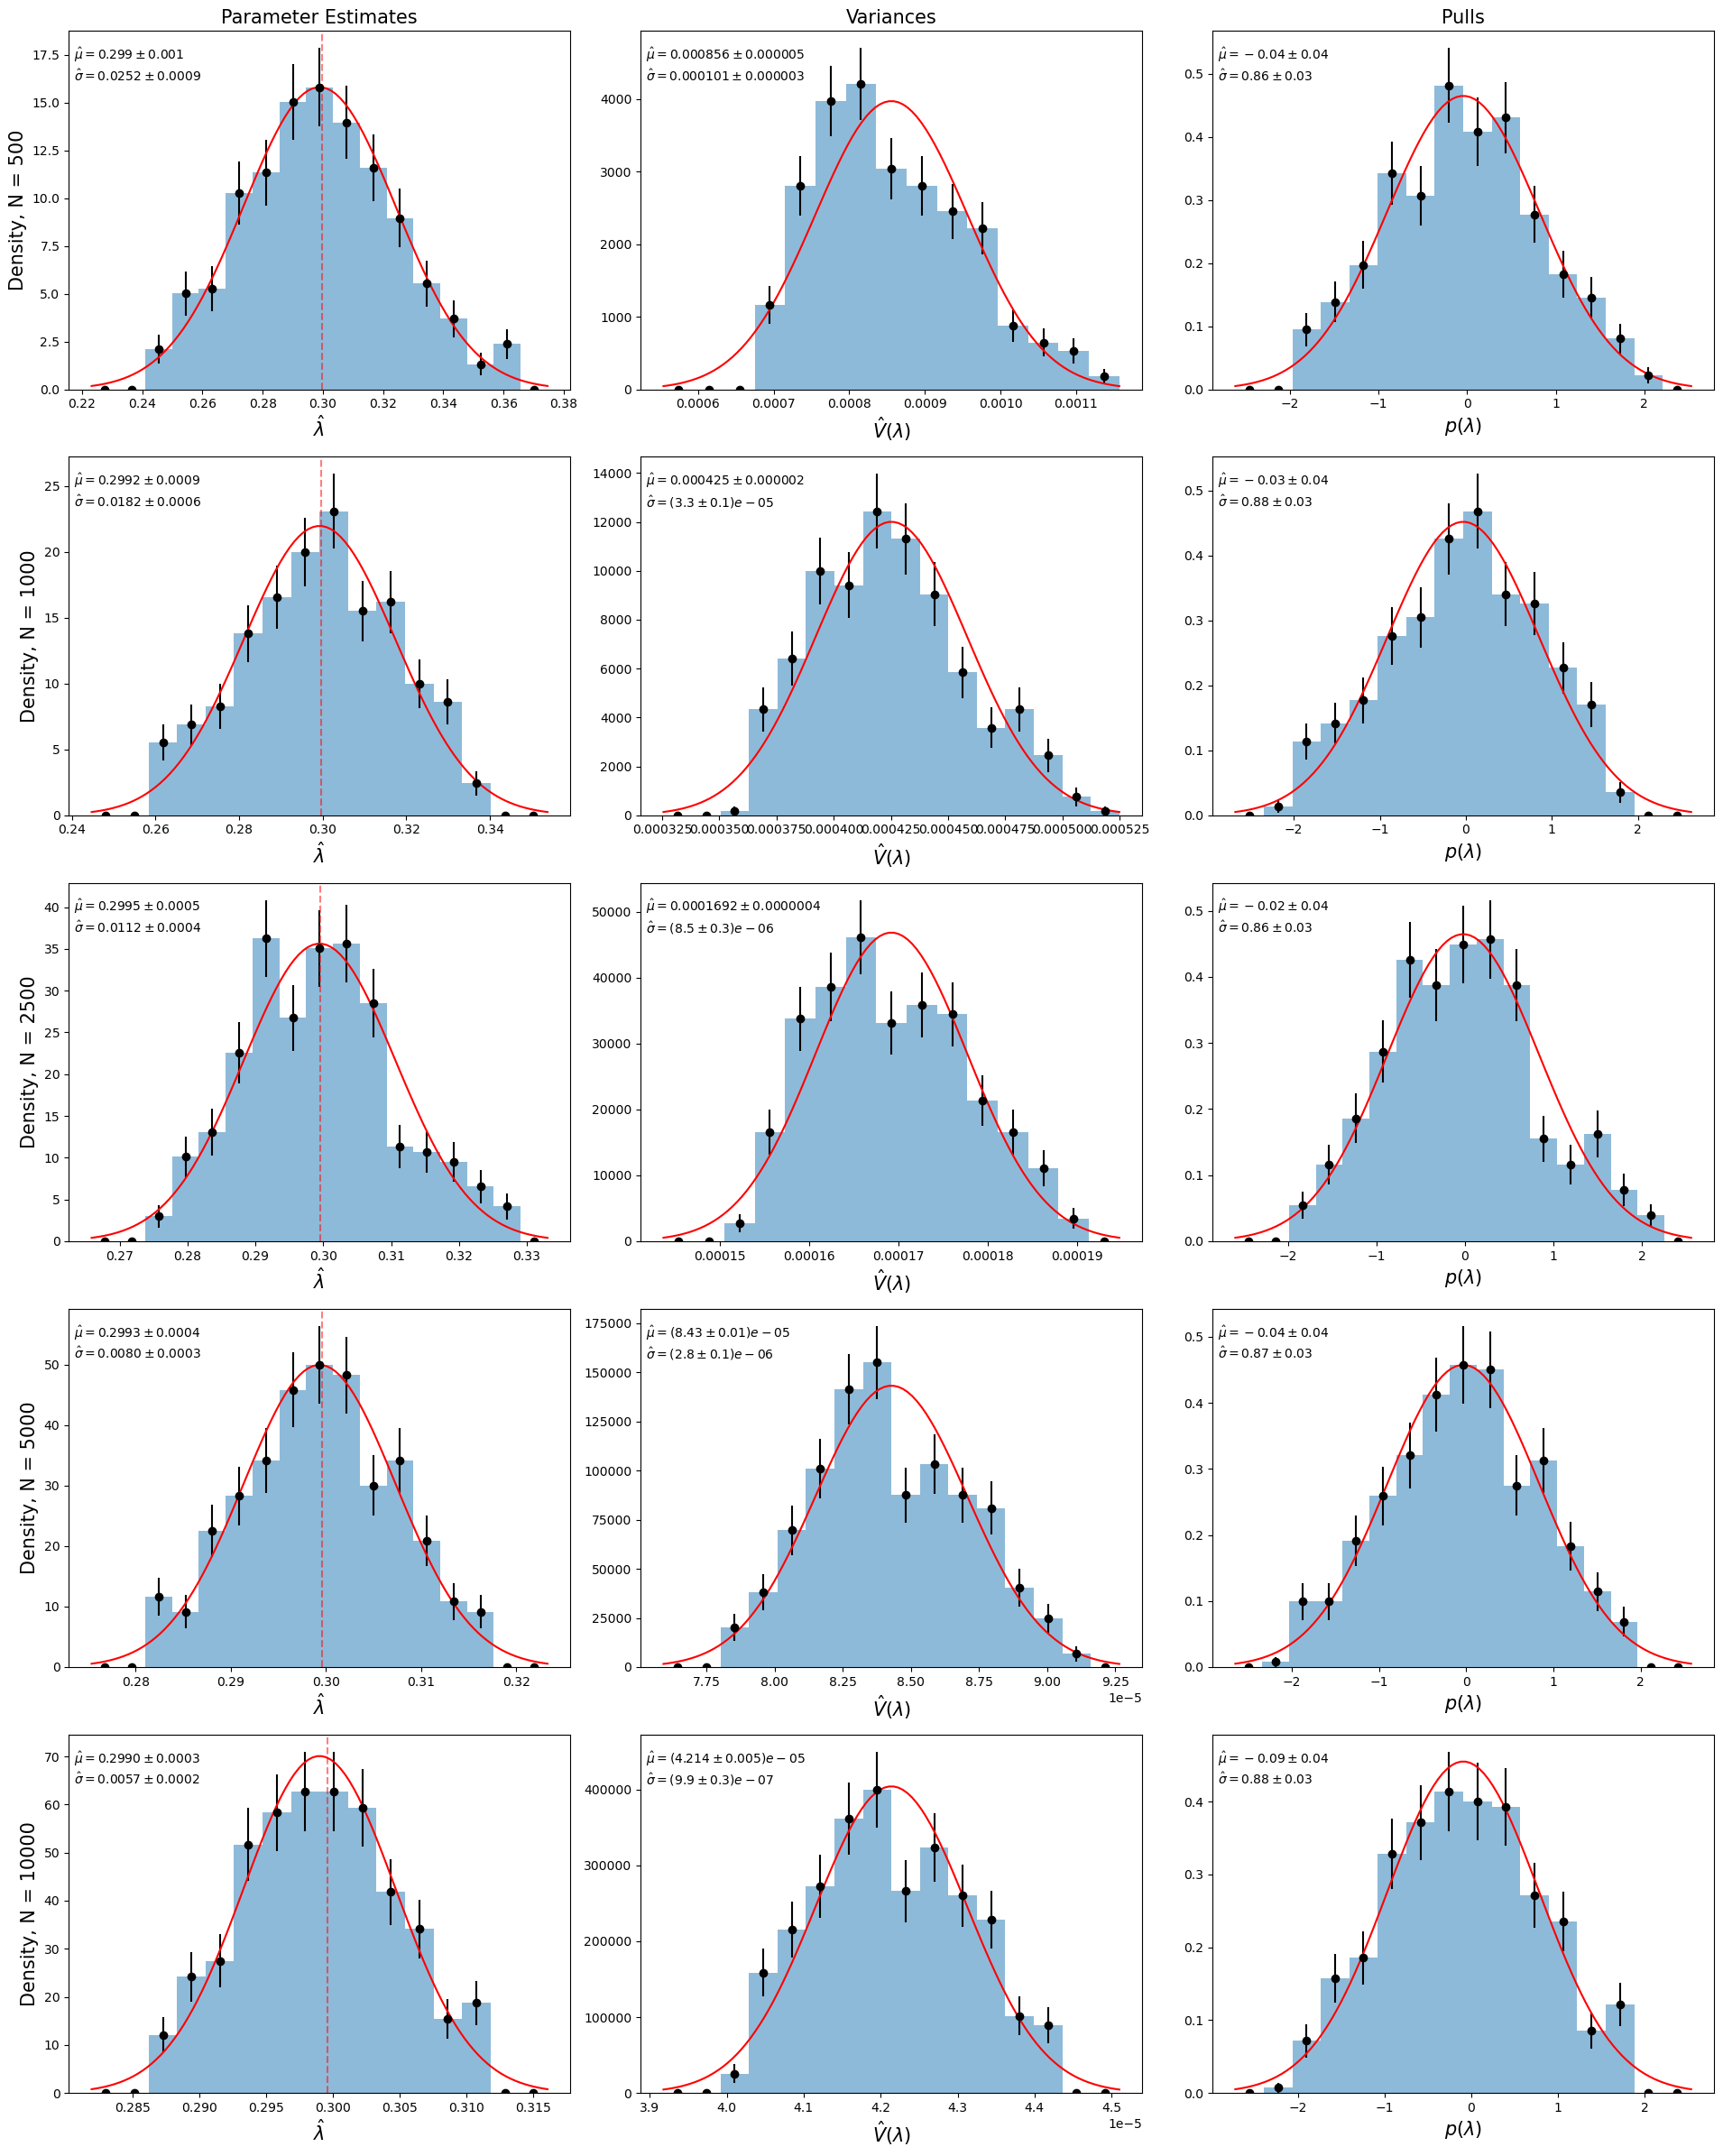

(<Figure size 1920x2400 with 15 Axes>,
 array([[<Axes: title={'center': 'Parameter Estimates'}, xlabel='$\\hat{\\lambda}$', ylabel='Density, N = 500'>,
         <Axes: title={'center': 'Variances'}, xlabel='$\\hat{{V}}(\\lambda)$'>,
         <Axes: title={'center': 'Pulls'}, xlabel='$p(\\lambda)$'>],
        [<Axes: xlabel='$\\hat{\\lambda}$', ylabel='Density, N = 1000'>,
         <Axes: xlabel='$\\hat{{V}}(\\lambda)$'>,
         <Axes: xlabel='$p(\\lambda)$'>],
        [<Axes: xlabel='$\\hat{\\lambda}$', ylabel='Density, N = 2500'>,
         <Axes: xlabel='$\\hat{{V}}(\\lambda)$'>,
         <Axes: xlabel='$p(\\lambda)$'>],
        [<Axes: xlabel='$\\hat{\\lambda}$', ylabel='Density, N = 5000'>,
         <Axes: xlabel='$\\hat{{V}}(\\lambda)$'>,
         <Axes: xlabel='$p(\\lambda)$'>],
        [<Axes: xlabel='$\\hat{\\lambda}$', ylabel='Density, N = 10000'>,
         <Axes: xlabel='$\\hat{{V}}(\\lambda)$'>,
         <Axes: xlabel='$p(\\lambda)$'>]], dtype=object))

In [135]:
def plot_lambda_comparison_all(N_samples, all_values, all_errors, all_pulls, param_names):
    
    # Find lambda index in param_names
    lambda_idx = param_names.index('\\lambda')
    
    # Create figure with 5x3 subplots (one row per N)
    fig, axes = plt.subplots(len(N_samples), 3, figsize=(19.2, 24))
    
    # Format parameter name for LaTeX
    base_name = 'lambda'
    
    for i, (N, values, errors, pulls) in enumerate(zip(N_samples, all_values, all_errors, all_pulls)):
        fitted_values_t = np.concatenate((np.array([N]), fitted_values))
        
        # Parameter values plot
        ax = axes[i, 0]
        plot(values[:, lambda_idx], ax, param_name=base_name, plot_param=True)
        ax.set_xlabel(r"$\hat{\lambda}$", fontsize=fontsize)
        ax.axvline(fitted_values_t[lambda_idx], color='r', linestyle='--', alpha=0.5)
        
        # Variance plot (errors squared)
        ax = axes[i, 1]
        plot(errors[:, lambda_idx]**2, ax, param_name=base_name, plot_var=True)
        ax.set_xlabel(r"$\hat{{V}}(\lambda)$", fontsize=fontsize)
        
        # Pulls plot
        ax = axes[i, 2]
        plot(pulls[:, lambda_idx], ax, param_name=base_name)
        ax.set_xlabel(r"$p(\lambda)$", fontsize=fontsize)
        
        # Add row label
        axes[i, 0].set_ylabel(f"Density, N = {N}", fontsize=fontsize)
    
    # Add column headers
    axes[0, 0].set_title("Parameter Estimates", fontsize=fontsize)
    axes[0, 1].set_title("Variances", fontsize=fontsize)
    axes[0, 2].set_title("Pulls", fontsize=fontsize)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'data_storage/bootstraps/lambda_plots/lambda_comparison.png')
    plt.show()
    
    return fig, axes

# Usage:
all_values = []
all_errors = []
all_pulls = []

for i in range(len(N_sample)):
    values, errors, pulls = load_data(data_list[i], cut_val=450)
    all_values.append(values)
    all_errors.append(errors) #because minuit gives back std not variances
    all_pulls.append(pulls)

plot_lambda_comparison_all(N_sample, all_values, all_errors, all_pulls, param_names)

In [73]:
param_names

['N', '\\mu', '\\sigma', '\\beta', 'm', 'f', '\\lambda', '\\mu_b', '\\sigma_b']

Plot all of the toys

In [81]:
# for i in range(len(N_sample)):
#     values, errors, pulls = load_data(data_list[i], cut_val = 450)
#     plot_toys(N_sample[i], values, errors, pulls, param_names)
    

In [93]:
#Get the average and std of the lambdas 
def get_lmbdas_mean(data_list):
    lmbdas_mean = []
    lmbdas_std = []
    for data in data_list:
        values, _, _ = load_data(data)
        lmbda_vals = values[:,6]
        print(len(lmbda_vals)) #check that they have the expected length
        lmbdas_mean.append(np.mean(lmbda_vals))
        lmbdas_std.append(np.std(lmbda_vals, ddof=1)/(np.sqrt(450)))
    return lmbdas_mean, lmbdas_std
lmbdas_mean, lmbdas_std = np.array(get_lmbdas_mean(data_list))
#find the bias
lmbdas_bias = lmbdas_mean - fitted_values[5]

450
450
450
450
450


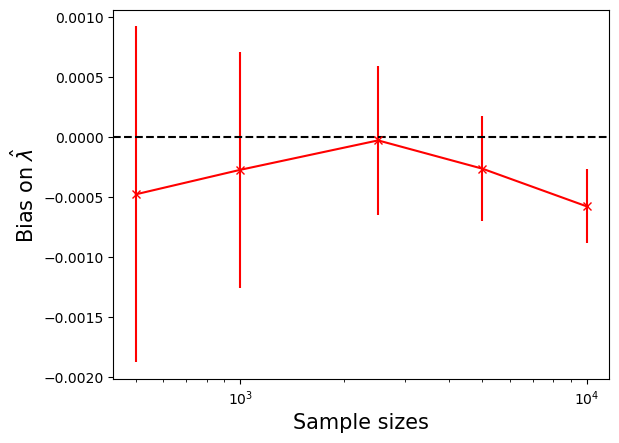

In [141]:
#plt.plot(N_sample, (lmbdas_bias), ls = '-')
plt.errorbar(N_sample, lmbdas_bias, yerr = lmbdas_std, fmt = 'rx', ls = '-')
plt.xscale('log')
plt.ylabel(r'Bias on $\hat{\lambda}$', fontsize = fontsize)
plt.xlabel('Sample sizes', fontsize = fontsize
           )
plt.axhline(y=0, color = 'black', ls = '--')
plt.savefig('data_storage/bootstraps/lambda_plots/MLE_bias.png', bbox_inches='tight')
np.savetxt('data_storage/bootstraps/lambda_plots/MLE_bias.csv', (lmbdas_bias, lmbdas_std), delimiter=',')

Plot the variance of the lambdas and check relationship: $V(\hat{\lambda}) \propto \frac{1}{N}$

In [56]:
def get_lmbdas_var(data_list):
    lmbdas_var = []
    lmbdas_var_std = []
    for data in data_list:
        _, errors, _ = load_data(data)
        var = errors[:,6] #this is actually the std 
        lmbdas_var.append(np.mean(var))
        lmbdas_var_std.append(np.std(var, ddof=1)/(np.sqrt(450)))
    return lmbdas_var, lmbdas_var_std
lmbdas_var, lmbdas_var_std = np.array(get_lmbdas_var(data_list))

error on the gradient:  0.0004345712563943781


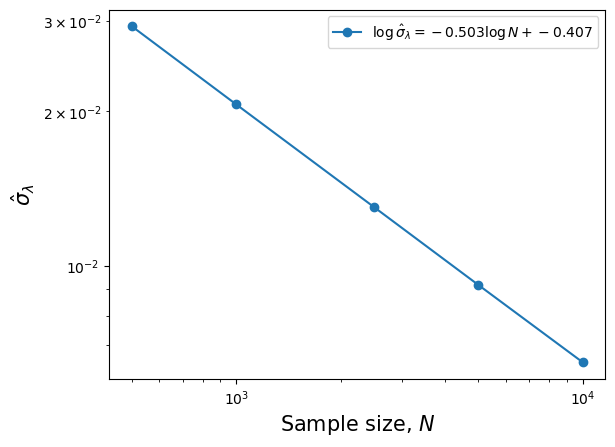

In [138]:
#Log-log plot should show linear line

log_var = np.log(lmbdas_var)
log_N = np.log(N_sample)
coeffs, cov = np.polyfit(log_N, log_var, 1, cov = True)

plt.plot(N_sample, lmbdas_var, 'o',ls = '-', label = rf'$\log{{\hat{{\sigma}}_{{\lambda}}}} = {coeffs[0]:.3f}\log{{N}} + {coeffs[1]:.3f}$')

#plt.errorbar(N_sample, lmbdas_var, yerr = lmbdas_var_std) error bars so small you cannot see them
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Sample size, $N$', fontsize = fontsize)
plt.ylabel(r'$\hat{\sigma}_{{{{\lambda}}}}$' , fontsize = fontsize)
plt.legend()
plt.savefig('data_storage/bootstraps/lambda_plots/var_lambda.png', bbox_inches='tight')

np.savetxt('data_storage/bootstraps/lambda_plots/MLE_var.csv', lmbdas_var, delimiter=',')
print('error on the gradient: ', np.sqrt(cov[0][0]))


## Part f: sWeights

In [109]:
N = 10000
Ns = int(f_true * N)
Nb = N - Ns

#New model density for X
def X_model_density(X, Ns, Nb, mu, sigma, beta, m):

    #define pdfs again here, because it is quicker for the minimiser
    g_s = crystalball.pdf(X, beta, m, mu, sigma) / (crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma))

    #g_b = uniform.pdf(X, 0.0, 5.0)
    g_b = np.where((X >= 0) & (X <= 5), 1/5.0, 0)

    signal = Ns * g_s
    background = Nb * g_b

    total = signal + background

    return Ns+Nb, total

#New EML fit for X
def EML_fit_X(): #using the true params as starting values
    nll = ExtendedUnbinnedNLL(X, X_model_density)

    mi = Minuit(nll, 
                Ns = Ns,
                Nb = Nb,
                mu=fitted_values[0],
                sigma=fitted_values[1],
                beta=fitted_values[2],
                m=fitted_values[3]
)

    #input limits
    mi.limits["Ns"] = (0, None)
    mi.limits["Nb"] = (0, None)
    mi.limits["beta"] = (0, None)
    mi.limits["m"] = (1, None)
    mi.limits["sigma"] = (0, 10)

    mi.migrad()
    mi.hesse()
    #mi.minos()
    

    return mi

In [110]:
#Testing data 
N = 10000
data = accept_reject_2d(total_fixed_fitted, num_samples=N)
X, Y = data
mi = EML_fit_X()
mi

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.377e+05                 │              Nfcn = 217              │
│ EDM = 0.000105 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Ns    │  6.14e3   │  0.14e3   │            │            │    0    │         │       │
│ 1 │ Nb    │  3.86e3   │  0.13e3   │            │            │    0    │         │       │
│ 2 │ mu    │   3.004   │   0.008   │            │            │         │         │       │
│ 3 │ sigma │   0.309   │   0.008   │            │            │    0    │   10    │       │
│ 4 │ beta  │   1.13    │   0.08    │            │            │    0    │         │       │
│ 5 │ m     │   1.14    │   0.17    │            │            │    1    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────┐
│       │         Ns         Nb         mu      sigma       beta          m │
├───────┼───────────────────────────────────────────────────────────────────┤
│    Ns │   1.97e+04   -0.014e6  -45.00e-3  384.32e-3      1.562    -10.002 │
│    Nb │   -0.014e6   1.75e+04   45.01e-3 -384.44e-3     -1.562     10.005 │
│    mu │  -45.00e-3   45.01e-3   6.12e-05   -0.03e-3   -0.31e-3    0.49e-3 │
│ sigma │  384.32e-3 -384.44e-3   -0.03e-3   6.43e-05    0.29e-3   -0.58e-3 │
│  beta │      1.562     -1.562   -0.31e-3    0.29e-3    0.00642     -0.013 │
│     m │    -10.002     10.005    0.49e-3   -0.58e-3     -0.013     0.0325 │
└───────┴───────────────────────────────────────────────────────────────────┘

In [111]:
#define pdfs to put into sWeights
spdf = lambda x: g_s(x, mi.values['beta'], mi.values['m'], mi.values['mu'], mi.values['sigma'])
bpdf = lambda x: g_b(x)

sweight = SWeight(X, [spdf, bpdf], yields = [mi.values['Ns'], mi.values['Nb']], discvarranges=([0,5],))

    PDF normalisations:
	 0 1.000000000080336
	 1 1.0000000000000002
    Integral of w*pdf matrix (should be close to the
                identity):
	[[9.99893743e-01 1.55590234e-04]
	 [1.09354634e-04 9.99862650e-01]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |  6137.8477 |  6137.8477 |     0.00% |
	  1        |  3862.2417 |  3862.2417 |     0.00% |


Plot the weights themselves.

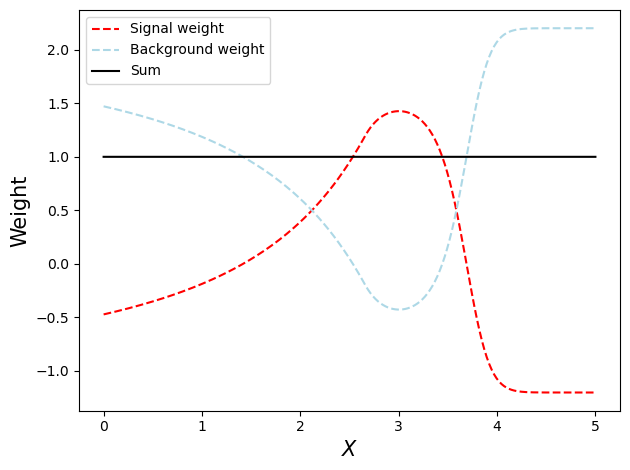

In [144]:
def plot_weights(x, sw, bw):
    plt.figure()
    plt.plot(x, sw, ls = '--', color = 'red', label="Signal weight")
    plt.plot(x, bw, ls = '--', color = 'lightblue', label="Background weight")
    plt.plot(x, sw + bw, "k-", label="Sum")
    plt.xlabel(r"$X$", fontsize = fontsize)
    plt.ylabel("Weight", fontsize = fontsize)
    plt.legend()
    plt.tight_layout()

#display the sWeights plot
x = np.linspace(0,5, 200)
swp = sweight.get_weight(0,x)
bwp = sweight.get_weight(1, x)
plot_weights(x, swp, bwp)

plt.savefig('plots/sweights_example.png', bbox_inches = 'tight')

Apply these weights to the dataset as a function of $Y$.

Text(0.5, 0, '$Y$')

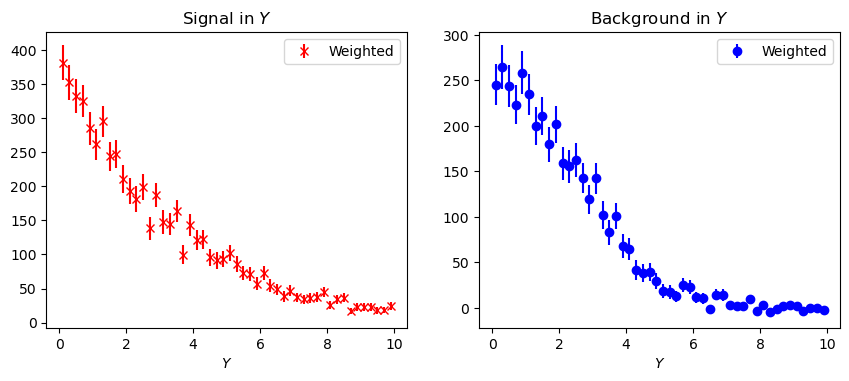

In [118]:
sw = sweight.get_weight(0, X)#using the actual X values, not linspace
bw = sweight.get_weight(1, X)

ysw, _ = np.histogram(Y, bins = 50, range = [0,10], weights = sw)
ybw, _ = np.histogram(Y, bins = 50, range = [0,10], weights = bw)

ysw2, _ = np.histogram(Y, bins = 50, range = [0,10], weights = sw**2)
ybw2, ye = np.histogram(Y, bins = 50, range = [0,10], weights = bw**2)

cy = 0.5 * (ye[1:] + ye[:-1])

fig, ax = plt.subplots(1, 2, figsize=(0.8*12.8, 0.8*4.8))

ax[0].errorbar( cy, ysw, ysw2**0.5, fmt='rx', label='Weighted' )
ax[0].set_title(r'Signal in $Y$')
ax[0].legend()
ax[1].errorbar( cy, ybw, ybw2**0.5, fmt='bo', label='Weighted' )
ax[1].set_title(r'Background in $Y$')
ax[1].legend()

ax[0].set_xlabel('$Y$')
ax[1].set_xlabel('$Y$')

Now use curve fit to fit the truncated exponential $h_s(Y)$ onto the signal in $Y$ and find $\hat{\lambda}$.

In [119]:
np.sum(sw)

6137.847722066672

Text(0, 0.5, 'Signal density')

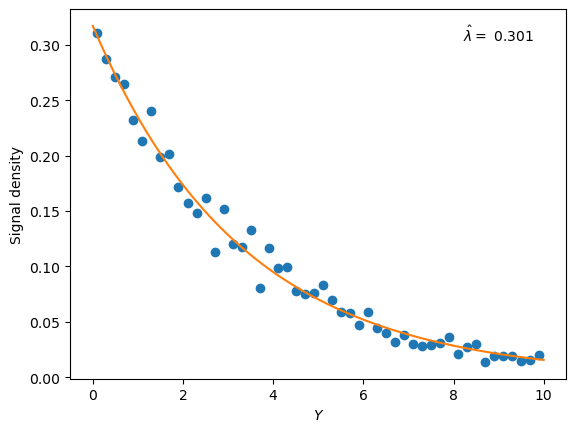

In [71]:
ysw, ye = np.histogram(Y, bins = 50, range = [0,10], weights = sw, density = True)
cy = 0.5 * (ye[1:] + ye[:-1]) 

#fit the histogram to the theoretical y signal distribution
popt, _ = curve_fit(lambda y, lmbda: h_s(y, lmbda), cy, ysw, fitted_values[5])
lmbda_sw = popt[0]

#plot the signal dist with the fitted values
y = np.linspace(0, 10, 200)
plt.plot(cy, ysw, 'o', label = 'Signal weight')
plt.plot(y, h_s(y, lmbda_sw))
plt.text(9, 0.31, r'$\hat{\lambda} =$ ' + f'{lmbda_sw:.3f}', horizontalalignment='center',verticalalignment='center')
plt.xlabel(r'$Y$')
plt.ylabel('Signal density')
